# Understanding variation in lifespans of notable people using the BHHT data

The [BHHT](https://medialab.github.io/bhht-datascape) (Brief History of Human Time) project provides a dataset about "notable people" based mainly on wikipedia biography articles.

The analyses below focus on lifespans of the people in the BHHT dataset, aiming to understand how lifespans vary based on factors including era of birth, the geographic region where the person lived, and the person's sex.

This analysis uses survival analysis methods, allowing us to use information from still-living people.

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pathlib import Path
from scipy.stats.distributions import chi2

Change the path below as needed to point to the directory containing the data file.

In [84]:
pa = Path("/Users/jiatao/Desktop/UMich/25Fall/STATS 485/case2/")

Load the dataset.  Use the latin-1 encoding since there is some non-UTF data in the file.  Add "nrows=####" when developing to reduce the run time, but always use the complete data to get final results.

In [85]:
df = pd.read_csv(pa / Path("cross-verified-database.csv.gz"), encoding="latin-1", nrows=500000)

Create a lifespan variable (years of life).  It will be missing for people who are currently living.

In [86]:
df["lifespan"] = df["death"] - df["birth"]

Exclude people born before 1500, this includes the vast majorityh of the data and gives us a narrower focus. We also exclude people born after 1970 as these people are not yet at high risk for many major causes of death.

In [87]:
dx = df.query("1500 <= birth <= 1970")

Retain only variables to be analyzed below.

In [88]:
dx = dx[["birth", "lifespan", "gender", "un_region"]]
dx.head()

,birth,lifespan,gender,un_region
0,1932.0,58.0,Male,Europe
1,1860.0,67.0,Male,Europe
4,1912.0,65.0,Female,Europe
5,1928.0,88.0,Male,America
6,1818.0,76.0,Male,Europe


There are a small number of people with missing or "Other" gender but it is too small of a sample to draw conclusions.

In [89]:
print(dx.gender.value_counts())
dx = dx.loc[dx["gender"].isin(["Female", "Male"]), :]

gender
Male      319730
Female     43152
Other         47
Name: count, dtype: int64


Censor lifespans at the last year when anyone died in the dataset.

In [71]:
censor_year = df["death"].max()
print("Censoring at %d" % censor_year)
dx["clifespan"] = dx["lifespan"].fillna(censor_year - dx["birth"])
dx["died"] = 1 - 1*dx["lifespan"].isnull()
dx.head()

Censoring at 2020


,birth,lifespan,gender,un_region,clifespan,died
0,1932.0,58.0,Male,Europe,58.0,1
1,1860.0,67.0,Male,Europe,67.0,1
4,1912.0,65.0,Female,Europe,65.0,1
5,1928.0,88.0,Male,America,88.0,1
6,1818.0,76.0,Male,Europe,76.0,1


Now we can drop all rows with missing data

In [52]:
dx = dx.drop("lifespan", axis=1)
dx = dx.dropna()
dx.head()

,birth,gender,un_region,clifespan,died
0,1932.0,Male,Europe,58.0,1
1,1860.0,Male,Europe,67.0,1
4,1912.0,Female,Europe,65.0,1
5,1928.0,Male,America,88.0,1
6,1818.0,Male,Europe,76.0,1


Calculate the proportion of people who have died (so their lifespans are known).  This is not a valid parameter for our longevity analysis, since it is largely dependent on the distribution of birth years.

In [12]:
dx["died"].mean()

np.float64(0.6338727920128465)

Create a categorical variable indicating the century in which a person was born.

In [13]:
dx["era"] = np.floor((dx["birth"] - 1500) / 100)
dx.head()

,birth,gender,un_region,clifespan,died,era
0,1932.0,Male,Europe,58.0,1,4.0
1,1860.0,Male,Europe,67.0,1,3.0
4,1912.0,Female,Europe,65.0,1,4.0
5,1928.0,Male,America,88.0,1,4.0
6,1818.0,Male,Europe,76.0,1,3.0


Another factor of interest is the region where the person lived, which has five levels coded as follows:

In [14]:
dx["un_region"].value_counts()

un_region
Europe     243542
America     80239
Asia        21889
Oceania      7378
Africa       5027
Name: count, dtype: int64

Two other factors of interest are gender and era (of birth).  Marginal distributions for these variables are as below:

In [15]:
dx["gender"].value_counts()

gender
Male      315424
Female     42651
Name: count, dtype: int64

In [16]:
dx["era"].value_counts()

era
4.0    223880
3.0     98599
2.0     22072
1.0      8189
0.0      5335
Name: count, dtype: int64

## Marginal survival functions

Below we plot the marginal survival functions for people born in each century.  These survival functions are estimated using the product limit (Kaplan-Meier) method.  Note that the curve for 1900 suggests that 10% of notable people live to be 100.  This is unlikely to be true, and could be due to improvements in health within the 20th century -- people born later in the 20th century are (by construction) more likely to be censored and also presumably have longer lifespans.  This results in dependent censoring, which biases the survival function estimates.

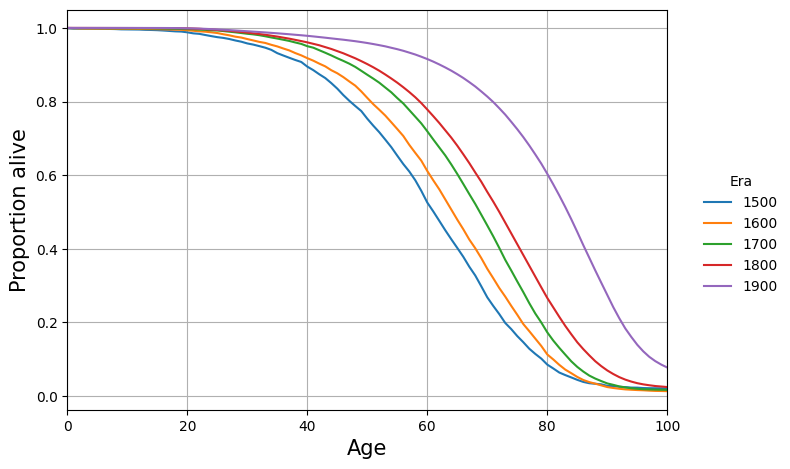

In [17]:
plt.figure(figsize=(8, 5))
plt.clf()
plt.axes([0.1, 0.1, 0.75, 0.8])
plt.grid(True)
for k,g in dx.groupby("era"):
    sf = sm.SurvfuncRight(g.clifespan, g.died)
    la = "%.0f" % (1500 + k*100)
    plt.plot(sf.surv_times, sf.surv_prob, label=la)
plt.xlim(0, 100)
plt.xlabel("Age", size=15)
plt.ylabel("Proportion alive", size=15)
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, loc="right", title="Era")
leg.draw_frame(False)

We can also estimate the marginal survival function for each gender and for each region.

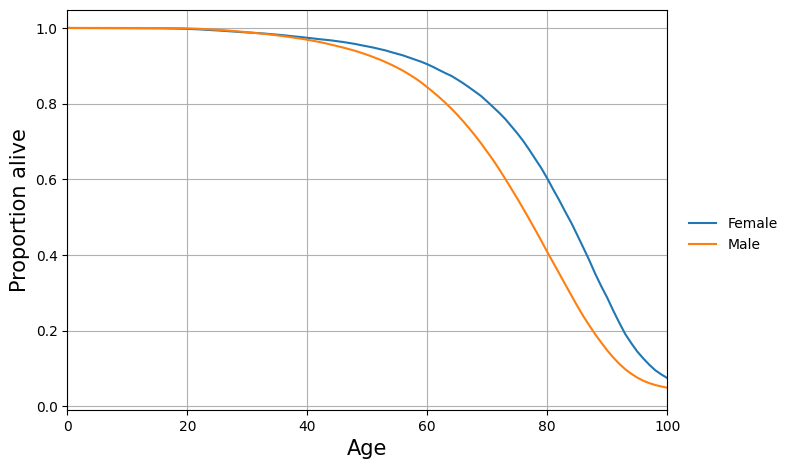

In [18]:
plt.figure(figsize=(8, 5))
plt.clf()
plt.axes([0.1, 0.1, 0.75, 0.8])
plt.grid(True)
for k,g in dx.groupby("gender"):
    sf = sm.SurvfuncRight(g.clifespan, g.died)
    plt.plot(sf.surv_times, sf.surv_prob, label=k)
plt.xlim(0, 100)
plt.xlabel("Age", size=15)
plt.ylabel("Proportion alive", size=15)
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, loc="right")
leg.draw_frame(False)

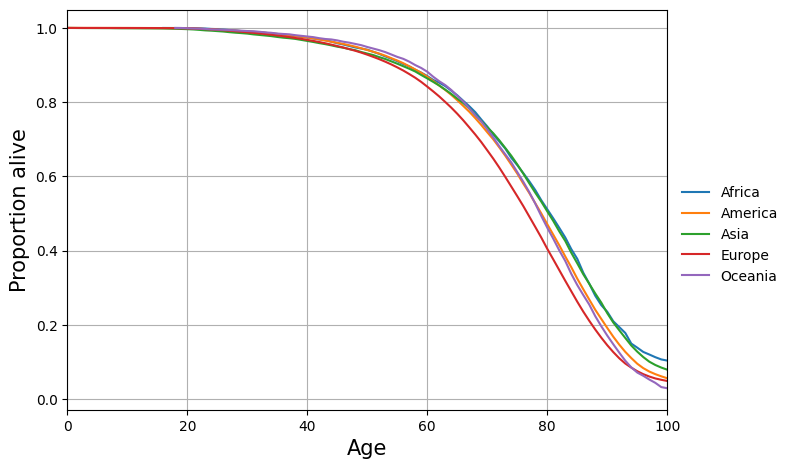

In [19]:
plt.figure(figsize=(8, 5))
plt.clf()
plt.axes([0.1, 0.1, 0.75, 0.8])
plt.grid(True)
for k,g in dx.groupby("un_region"):
    sf = sm.SurvfuncRight(g.clifespan, g.died)
    plt.plot(sf.surv_times, sf.surv_prob, label=k)
plt.xlim(0, 100)
plt.xlabel("Age", size=15)
plt.ylabel("Proportion alive", size=15)
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, loc="right")
leg.draw_frame(False)

The results above may be heavily influenced by confounding.  The people from Oceania tended to live more recently, and people who lived more recently tend to have longer lifespans.  Conversely, many of the notable people from the 1500's-1700's are from Europe, and lifespans tended to be shorter in these historical eras. Looking at one factor at a time, it is not clear whether the "driver" of lifespan variation is geography (where a person lived) or time (when a person lived).

## Marginal hazard functions

A very important concept in survival analysis is the hazard function.  In this case, since the times are discrete (ages are in whole years), we can estimate the hazard easily as the ratio of the number of events (deaths) to the number at risk, for each age.  These are plotted below, stratified by era.

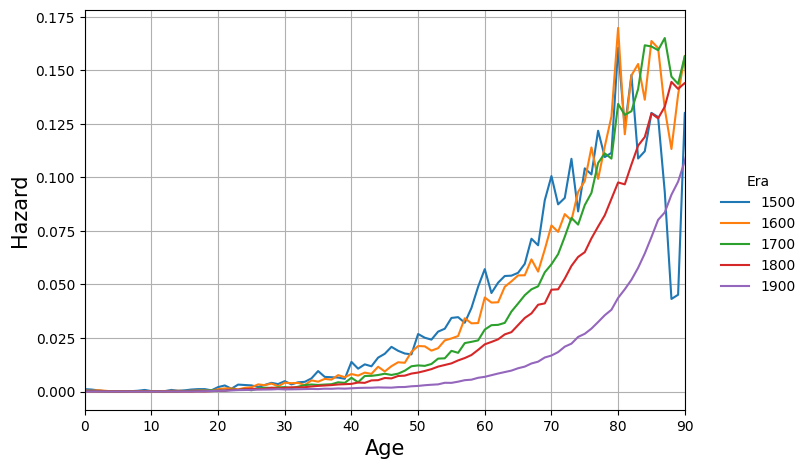

In [20]:
plt.figure(figsize=(8, 5))
plt.clf()
plt.axes([0.1, 0.1, 0.75, 0.8])
plt.grid(True)
for k,g in dx.groupby("era"):
    sf = sm.SurvfuncRight(g.clifespan, g.died)
    la = "%.0f" % (1500 + k*100)
    plt.plot(sf.surv_times, sf.n_events/sf.n_risk, label=la)
plt.xlabel("Age", size=15)
plt.ylabel("Hazard", size=15)
plt.xlim(0, 90)
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, loc="right", title="Era")
leg.draw_frame(False)

Below we estimate and plot the (marginal) hazard function for each gender.

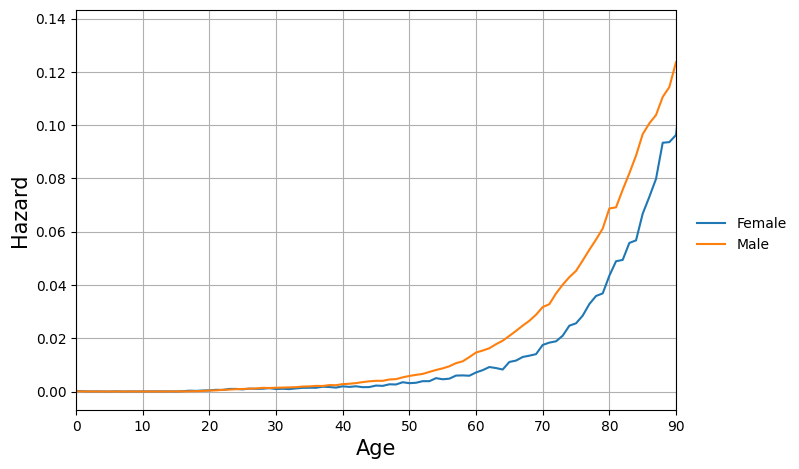

In [21]:
plt.figure(figsize=(8, 5))
plt.clf()
plt.axes([0.1, 0.1, 0.75, 0.8])
plt.grid(True)
for k,g in dx.groupby("gender"):
    sf = sm.SurvfuncRight(g.clifespan, g.died)
    plt.plot(sf.surv_times, sf.n_events/sf.n_risk, label=k)
plt.xlabel("Age", size=15)
plt.ylabel("Hazard", size=15)
plt.xlim(0, 90)
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, loc="right")
leg.draw_frame(False)

## Proportional hazard modeling

Create a translated birth year setting year 1500 as year zero.  This makes it easier to interpret the proportional hazard regression models so that effects are relative to 1500 as a reference year.

In [22]:
dx["birth1500"] = dx["birth"] - 1500

Fit a proportional hazards regression model

In [23]:
fml = "clifespan ~ birth1500 + gender + un_region"
m0 = sm.PHReg.from_formula(fml, dx, status="died")
r0 = m0.fit()
r0.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: PHReg
============================================================================
Model:                       PH Reg             Sample size:          358075
Dependent variable:          clifespan          Num. events:          226974
Ties:                        Breslow                                        
----------------------------------------------------------------------------
                      log HR log HR SE   HR       t     P>|t|  [0.025 0.975]
----------------------------------------------------------------------------
gender[T.Male]        0.3019    0.0077 1.3524   39.1798 0.0000 1.3322 1.3730
un_region[T.America]  0.0375    0.0225 1.0382    1.6665 0.0956 0.9934 1.0850
un_region[T.Asia]    -0.0363    0.0241 0.9643   -1.5069 0.1318 0.9198 1.0110
un_region[T.Europe]   0.0585    0.0222 1.0603    2.6356 0.0084 1.0151 1.1074
un_region[T.Oceania]  0.0897    0.0267 1.0939    3.3587 0.0008 1.0381 1.1527
birth1500            -0.0047    0.0000 0.9953 -214.5599 0.0000 0.9952 0.9953
============================================================================
Confidence intervals are for the hazard ratios
"""

We use partial regression plots to visualize the fitted model.  The function implemented below plots the partial effect of birth year on the log hazard.

In [24]:
def plot_birthyear_partial(dx, rr):
    dp = dx.iloc[0:100, :].copy()
    dp["gender"] = "Female"
    # Region is arbitrary but must be fixed
    dp["un_region"] = "Africa"
    dp["birth"] = np.linspace(1500, 1970, 100)
    dp["birth1500"] = dp["birth"] - 1500
    lhr = rr.predict(exog=dp).predicted_values

    plt.clf()
    plt.grid(True)
    plt.plot(dp["birth"].values, lhr)
    plt.xlabel("Birth year", size=15)
    plt.ylabel("Contribution to the log hazard", size=15)

In the first model, there is a linear main effect for birth year.  The hazard of death is decreasing as year of birth increases.

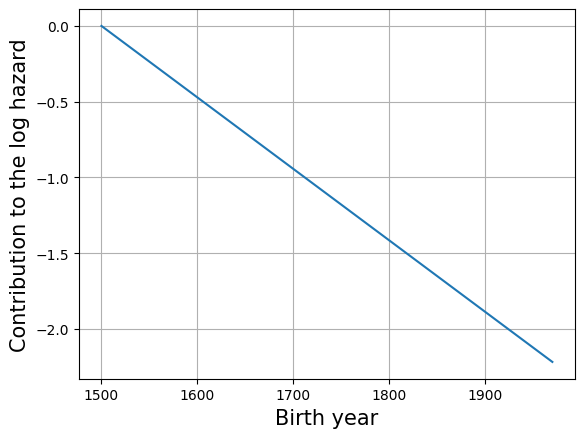

In [25]:
plot_birthyear_partial(dx, r0)

Next we include a quadratic effect for birth year, to see if the relationship between year of birth and log mortality hazard might be curved (parabolic), holding all other variables fixed. 

In [26]:
fml = "clifespan ~ birth1500 + I(birth1500**2) + gender + un_region"
m1 = sm.PHReg.from_formula(fml, dx, status="died")
r1 = m1.fit()
r1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: PHReg
============================================================================
Model:                       PH Reg             Sample size:          358075
Dependent variable:          clifespan          Num. events:          226974
Ties:                        Breslow                                        
----------------------------------------------------------------------------
                      log HR log HR SE   HR       t     P>|t|  [0.025 0.975]
----------------------------------------------------------------------------
gender[T.Male]        0.2471    0.0077 1.2804   31.9983 0.0000 1.2611 1.2999
un_region[T.America] -0.0760    0.0225 0.9268   -3.3743 0.0007 0.8868 0.9686
un_region[T.Asia]    -0.0395    0.0241 0.9613   -1.6378 0.1015 0.9169 1.0078
un_region[T.Europe]  -0.0574    0.0222 0.9442   -2.5848 0.0097 0.9039 0.9862
un_region[T.Oceania] -0.0262    0.0267 0.9741   -0.9805 0.3268 0.9244 1.0265
birth1500             0.0082    0.0001 1.0082   63.5001 0.0000 1.0080 1.0085
I(birth1500 ** 2)    -0.0000    0.0000 1.0000 -106.4852 0.0000 1.0000 1.0000
============================================================================
Confidence intervals are for the hazard ratios
"""

Since the quadratic term for year of birth is statistically significant, there is evidence for curvature in the relationship between birth year and mortality hazard.  However this model could be mis-specified -- the true relationship might be non-quadratic.

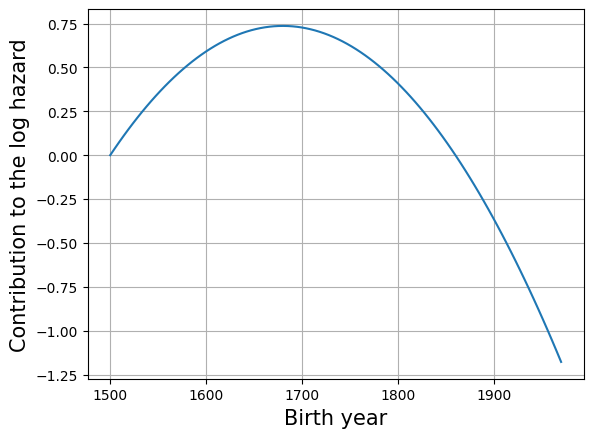

In [27]:
plot_birthyear_partial(dx, r1)

Next we add a cubic term to the model.

In [28]:
fml = "clifespan ~ birth1500 + I(birth1500**2) + I(birth1500**3) + gender + un_region"
m2 = sm.PHReg.from_formula(fml, dx, status="died")
r2 = m2.fit()
r2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: PHReg
===========================================================================
Model:                        PH Reg            Sample size:         358075
Dependent variable:           clifespan         Num. events:         226974
Ties:                         Breslow                                      
---------------------------------------------------------------------------
                      log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
---------------------------------------------------------------------------
gender[T.Male]        0.2365    0.0077 1.2668  30.6220 0.0000 1.2478 1.2861
un_region[T.America] -0.1247    0.0225 0.8827  -5.5353 0.0000 0.8446 0.9226
un_region[T.Asia]    -0.0663    0.0241 0.9358  -2.7511 0.0059 0.8926 0.9811
un_region[T.Europe]  -0.0984    0.0222 0.9063  -4.4245 0.0000 0.8677 0.9467
un_region[T.Oceania] -0.0896    0.0268 0.9143  -3.3485 0.0008 0.8676 0.9635
birth1500            -0.0129    0.0003 0.9872 -40.5507 0.0000 0.9866 0.9878
I(birth1500 ** 2)     0.0001    0.0000 1.0001  51.0973 0.0000 1.0001 1.0001
I(birth1500 ** 3)    -0.0000    0.0000 1.0000 -67.2431 0.0000 1.0000 1.0000
===========================================================================
Confidence intervals are for the hazard ratios
"""

Based on this model, the mortality hazard was fairly constant until around 1800, then it began to drop.

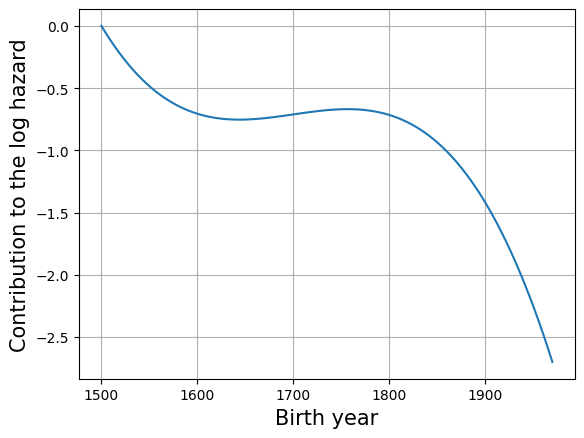

In [29]:
plot_birthyear_partial(dx, r2)

High order polynomials make poor basis functions.  A more effective approach is polynomial splines, which are piecewise polynomials.  Below we use a cubic spline basis with four degrees of freedom to capture the birth year effect.

In [30]:
fml = "clifespan ~ bs(birth1500, 4) + gender + un_region"
m3 = sm.PHReg.from_formula(fml, dx, status="died")
r3 = m3.fit()
r3.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: PHReg
===========================================================================
Model:                        PH Reg            Sample size:         358075
Dependent variable:           clifespan         Num. events:         226974
Ties:                         Breslow                                      
---------------------------------------------------------------------------
                      log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
---------------------------------------------------------------------------
gender[T.Male]        0.2364    0.0077 1.2667  30.6080 0.0000 1.2477 1.2860
un_region[T.America] -0.1249    0.0225 0.8826  -5.5402 0.0000 0.8445 0.9225
un_region[T.Asia]    -0.0665    0.0241 0.9357  -2.7579 0.0058 0.8925 0.9809
un_region[T.Europe]  -0.0985    0.0222 0.9062  -4.4309 0.0000 0.8676 0.9466
un_region[T.Oceania] -0.0897    0.0268 0.9142  -3.3510 0.0008 0.8675 0.9635
bs(birth1500, 4)[0]  -1.7952    0.0468 0.1661 -38.3976 0.0000 0.1515 0.1820
bs(birth1500, 4)[1]   0.7773    0.0219 2.1756  35.4208 0.0000 2.0840 2.2712
bs(birth1500, 4)[2]  -2.2892    0.0245 0.1013 -93.3713 0.0000 0.0966 0.1063
bs(birth1500, 4)[3]  -2.7179    0.0359 0.0660 -75.6552 0.0000 0.0615 0.0708
===========================================================================
Confidence intervals are for the hazard ratios
"""

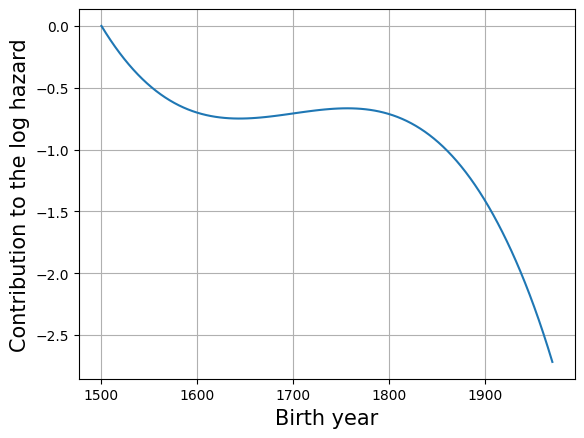

In [31]:
plot_birthyear_partial(dx, r3)

Above we found that year of birth is a strong predictor of the mortality hazard.  We also have a strong sex difference, with males having a much greater hazard.  Next we consider whether the year of birth effect differs by sex.

In [32]:
fml = "clifespan ~ bs(birth1500, 4) * gender + un_region"
m4 = sm.PHReg.from_formula(fml, dx, status="died")
r4 = m4.fit()
r4.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: PHReg
=========================================================================================
Model:                            PH Reg                 Sample size:              358075
Dependent variable:               clifespan              Num. events:              226974
Ties:                             Breslow                                                
-----------------------------------------------------------------------------------------
                                    log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
-----------------------------------------------------------------------------------------
gender[T.Male]                     -0.2657    0.1032 0.7667  -2.5734 0.0101 0.6262 0.9386
un_region[T.America]               -0.1228    0.0225 0.8844  -5.4489 0.0000 0.8462 0.9244
un_region[T.Asia]                  -0.0663    0.0241 0.9358  -2.7507 0.0059 0.8926 0.9811
un_region[T.Europe]                -0.0967    0.0222 0.9079  -4.3486 0.0000 0.8691 0.9483
un_region[T.Oceania]               -0.0869    0.0268 0.9168  -3.2477 0.0012 0.8699 0.9661
bs(birth1500, 4)[0]                -2.1450    0.2110 0.1171 -10.1657 0.0000 0.0774 0.1770
bs(birth1500, 4)[1]                 0.5615    0.0955 1.7533   5.8767 0.0000 1.4539 2.1144
bs(birth1500, 4)[2]                -2.8924    0.1099 0.0554 -26.3232 0.0000 0.0447 0.0688
bs(birth1500, 4)[3]                -3.2637    0.1204 0.0382 -27.1080 0.0000 0.0302 0.0484
bs(birth1500, 4)[0]:gender[T.Male]  0.3775    0.2163 1.4586   1.7449 0.0810 0.9545 2.2289
bs(birth1500, 4)[1]:gender[T.Male]  0.2146    0.0981 1.2394   2.1873 0.0287 1.0226 1.5023
bs(birth1500, 4)[2]:gender[T.Male]  0.6382    0.1127 1.8930   5.6627 0.0000 1.5178 2.3609
bs(birth1500, 4)[3]:gender[T.Male]  0.5918    0.1259 1.8072   4.7021 0.0000 1.4122 2.3128
=========================================================================================
Confidence intervals are for the hazard ratios
"""

To assess whether the birthyear x gender interaction is significant, we can use a log-likelihood ratio test:

In [33]:
stat = 2*(r4.llf - r3.llf)
dof = len(r4.params) - len(r3.params)
print("stat=", stat)
print("dof=", dof)
1 - chi2(dof).cdf(stat)

stat= 143.4963349495083
dof= 4


np.float64(0.0)

To understand the meaning of the interaction, we plot below the sex-specific contributions of year of birth to the log hazard.

In [34]:
def plot_birthyear_partial_sexdiff(dx, rr):
    dp = dx.iloc[0:200, :].copy()
    dp["gender"] = np.concatenate((["Female"]*100, ["Male"]*100))
    dp["female"] = np.concatenate((np.ones(100), np.zeros(100)))
    dp["un_region"] = "Africa"
    b = np.linspace(1500, 1970, 100)
    dp["birth"] = np.concatenate((b, b))
    dp["birth1500"] = dp["birth"] - 1500
    lhr = rr.predict(exog=dp).predicted_values

    plt.figure(figsize=(8, 5))
    plt.clf()
    plt.axes([0.1, 0.1, 0.75, 0.8])
    plt.grid(True)
    plt.plot(dp.iloc[0:100, :]["birth"].values, lhr[0:100], label="Female")
    plt.plot(dp.iloc[100:200, :]["birth"].values, lhr[100:200], label="Male")
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, loc="center right")
    leg.draw_frame(False)
    plt.xlabel("Birth year", size=15)
    plt.ylabel("Contribtution to the log hazard", size=15)

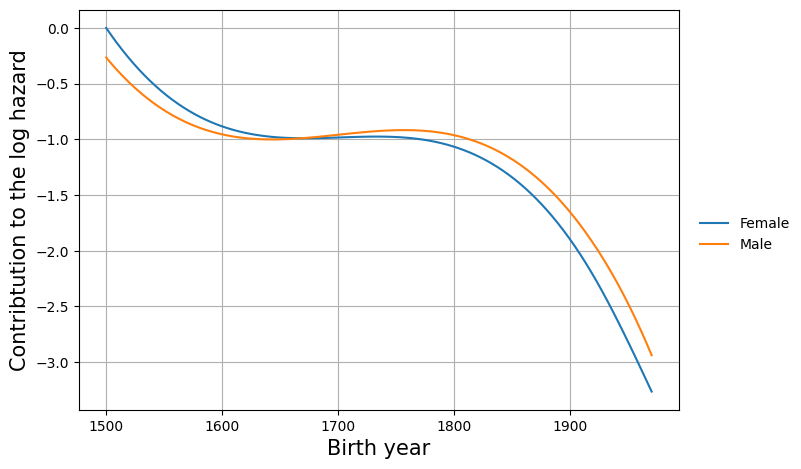

In [35]:
plot_birthyear_partial_sexdiff(dx, r4)

Above we considered an interaction between a categorical variable (gender) and a quantitative variable (birth1500).  Since the quantitative variable was modeled with splines, this createst an interaction between the gender indicator and each basis function of birth1500.  A more parsimonious way to model interactions involving splines is to model that main effect with a spline, but use only linear terms for the interaction.  This technique is illustrated below.

In [36]:
dx["female"] = (dx["gender"] == "Female").astype(int)
fml = "clifespan ~ bs(birth1500, 4) + female + birth1500 : female + un_region"
m5 = sm.PHReg.from_formula(fml, dx, status="died")
r5 = m5.fit()
r5.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: PHReg
===========================================================================
Model:                        PH Reg            Sample size:         358075
Dependent variable:           clifespan         Num. events:         226974
Ties:                         Breslow                                      
---------------------------------------------------------------------------
                      log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
---------------------------------------------------------------------------
un_region[T.America] -0.1228    0.0225 0.8845  -5.4468 0.0000 0.8463 0.9244
un_region[T.Asia]    -0.0664    0.0241 0.9357  -2.7549 0.0059 0.8925 0.9810
un_region[T.Europe]  -0.0966    0.0222 0.9079  -4.3440 0.0000 0.8692 0.9484
un_region[T.Oceania] -0.0870    0.0268 0.9167  -3.2511 0.0011 0.8699 0.9660
bs(birth1500, 4)[0]  -1.7815    0.0468 0.1684 -38.0454 0.0000 0.1536 0.1846
bs(birth1500, 4)[1]   0.7871    0.0220 2.1970  35.7962 0.0000 2.1043 2.2938
bs(birth1500, 4)[2]  -2.2587    0.0247 0.1045 -91.3880 0.0000 0.0995 0.1097
bs(birth1500, 4)[3]  -2.6728    0.0362 0.0691 -73.9321 0.0000 0.0643 0.0741
female                0.2694    0.0421 1.3092   6.3948 0.0000 1.2054 1.4219
birth1500:female     -0.0013    0.0001 0.9987 -12.1259 0.0000 0.9985 0.9989
===========================================================================
Confidence intervals are for the hazard ratios
"""

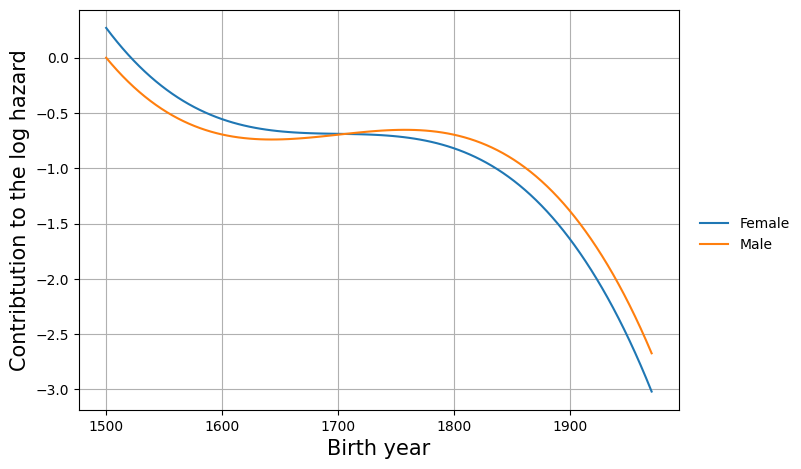

In [37]:
plot_birthyear_partial_sexdiff(dx, r5)

## Baseline hazard functions

The estimated baseline cumulative hazard function reflects the age-specific hazard of death, controlling for all covariates in the model.  The  cumulative hazard is easy to estimate but not straightforward to interpret.

Text(0, 0.5, 'Cumulative hazard')

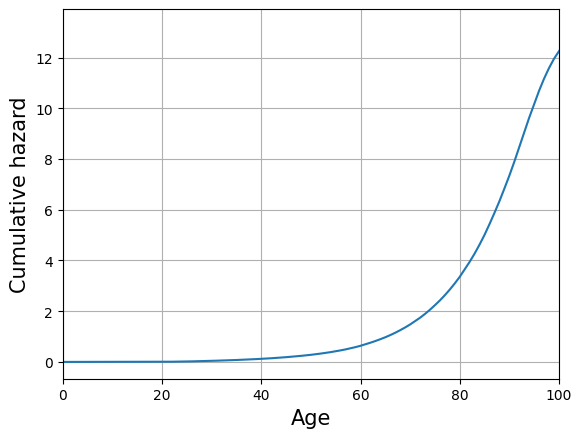

In [38]:
ti, cumhaz, surv = r0.baseline_cumulative_hazard[0]

plt.clf()
plt.grid(True)
plt.plot(ti, cumhaz)
plt.xlim(0, 100)
plt.xlabel("Age", size=15)
plt.ylabel("Cumulative hazard", size=15)

Estimate and plot the baseline cumulative hazard function on the log scale

Text(0, 0.5, 'Log cumulative hazard')

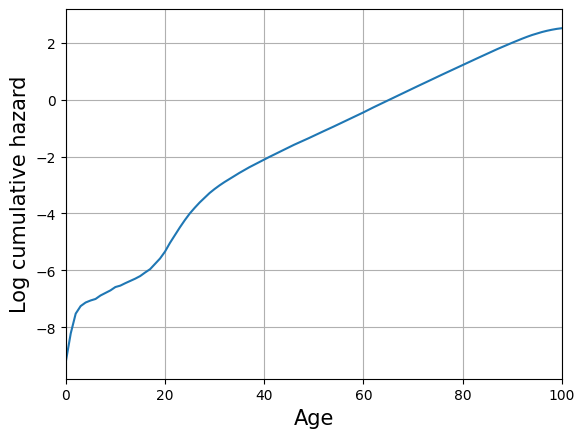

In [39]:
ti, cumhaz, surv = r0.baseline_cumulative_hazard[0]

plt.clf()
plt.grid(True)
plt.plot(ti, np.log(np.clip(cumhaz, 1e-4, np.inf)))
plt.xlim(0, 100)
plt.xlabel("Age", size=15)
plt.ylabel("Log cumulative hazard", size=15)

Next we estimate and plot the baseline hazard function using numerical differentiation

Text(0, 0.5, 'log hazard')

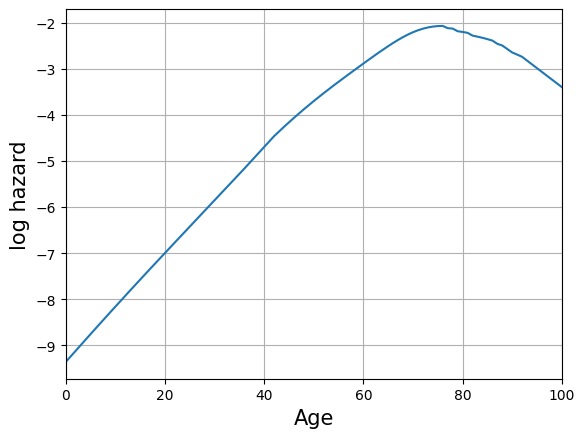

In [40]:
ti, chaz, surv = r0.baseline_cumulative_hazard[0]
haz = np.diff(chaz) / np.diff(ti)
shaz = sm.nonparametric.lowess(np.log(haz), ti[0:-1])

plt.clf()
plt.grid(True)
plt.plot(shaz[:, 0], shaz[:, 1])
plt.xlim(0, 100)
plt.xlabel("Age", size=15)
plt.ylabel("log hazard", size=15)

# Stratification

Fit a sex-stratified proportional hazards regression model

In [41]:
fml = "clifespan ~ bs(birth, 4) + un_region"
m6 = sm.PHReg.from_formula(fml, dx, status="died", strata="gender")
r6 = m6.fit()
r6.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: PHReg
===========================================================================
Model:                     PH Reg          Num strata:             2       
Dependent variable:        clifespan       Min stratum size:       42651   
Ties:                      Breslow         Max stratum size:       315424  
Sample size:               358075          Avg stratum size:       179037.5
Num. events:               226974                                          
---------------------------------------------------------------------------
                      log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
---------------------------------------------------------------------------
un_region[T.America] -0.1258    0.0225 0.8818  -5.5817 0.0000 0.8437 0.9216
un_region[T.Asia]    -0.0679    0.0241 0.9343  -2.8157 0.0049 0.8912 0.9796
un_region[T.Europe]  -0.0995    0.0222 0.9053  -4.4765 0.0000 0.8667 0.9456
un_region[T.Oceania] -0.0906    0.0268 0.9134  -3.3856 0.0007 0.8667 0.9626
bs(birth, 4)[0]      -1.8006    0.0468 0.1652 -38.5006 0.0000 0.1507 0.1811
bs(birth, 4)[1]       0.7687    0.0219 2.1569  35.0200 0.0000 2.0661 2.2517
bs(birth, 4)[2]      -2.2901    0.0245 0.1013 -93.3732 0.0000 0.0965 0.1062
bs(birth, 4)[3]      -2.7328    0.0360 0.0650 -75.9311 0.0000 0.0606 0.0698
===========================================================================
Confidence intervals are for the hazard ratios
"""

Plot the estimated baseline hazard function for each sex:

<Figure size 640x480 with 0 Axes>

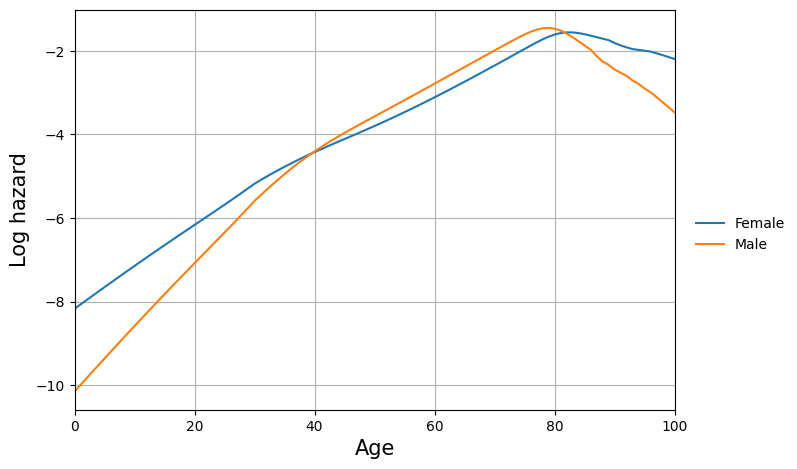

In [42]:
bh = r6.baseline_cumulative_hazard
snames = m6.surv.stratum_names

plt.clf()
plt.figure(figsize=(8, 5))
plt.axes([0.1, 0.1, 0.75, 0.8])
plt.grid(True)
for k in 0,1:
    ti = bh[k][0]
    chaz = bh[k][1]
    haz = np.diff(chaz) / np.diff(ti)
    shaz = sm.nonparametric.lowess(np.log(haz), ti[0:-1], frac=0.5)
    plt.plot(shaz[:,0], shaz[:,1], label=snames[k])
plt.xlabel("Age", size=15)
plt.ylabel("Log hazard", size=15)
plt.xlim(0, 100)
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, loc="right")
leg.draw_frame(False)